In [3]:
import random
import numpy as np

class Ship:
    def __init__(self, size):
        self.row = random.randrange(0,14)
        self.col = random.randrange(0,14)
        self.size = size
        self.orientation = random.choice(["h","v"])
        self.indexes = self.compute_indexes()

    def compute_indexes(self):
        start_index = self.row * 15 + self.col
        if self.orientation == "h":
            if start_index +self.size -1 >224:
                self.col = max(0,14 - (self.size -1))
                start_index = self.row *15 +self.col
            return[start_index + i for i in range(self.size)]
        elif self.orientation =="v":
            if self.row +self.size -1 >14:
                self.row = max(0,14 - (self.size -1))
                start_index = self.row * 15 + self.col
            return [start_index + i *15 for i in range(self.size)]
class Player:
    def __init__(self):
        self.ships = []
        self.search = ["U" for i in range(225)] # "U" for "unknown"
        self.place_ships(sizes = [5,4,3,3,2])
        list_of_lists = [ship.indexes for ship in self.ships]
        self.indexes = [index for sublist in list_of_lists for index in sublist]
    def place_ships(self,sizes):
        for size in sizes:
            placed = False
            while not placed:
                #create new ship
                ship = Ship(size)
                #is placememnt possible
                possible = True
                for i in ship.indexes:

                    if i>=224:
                        possible = False
                        break

                    #ships cannot behave like a snake
                    new_row = i //15
                    new_col = i % 15
                    if new_row != ship.row and new_col != ship.col:
                        possible = False
                        break
                    for other_ship in self.ships:
                        if i in other_ship.indexes:
                            possible = False
                            break
                    if possible:
                        self.ships.append(ship)
                        placed = True
    def show_ships(self):
        indexes = ['-'if i not in self.indexes else "X" for i in range(225)]
        for row in range(15):
            print(" ".join(indexes[(row-1)*15:row*15]))

class Game:
    def __init__(self, human1, human2):
        self.human1 = human1
        self.human2 = human2
        self.player1 = Player()
        self.player2 = Player()
        self.player1_turn = True
        self.computer_turn = True if not self.human1 else False
        self.over = False
        self.result = None
        self.n_shots = 0
        self.q_table = {}  # Q-table
        self.epsilon = 0.5 # Exploration rate
        self.alpha = 0.1  # Learning rate
        self.gamma = 0.9  # Discount factor
       
    def make_move(self, i):
        player = self.player1 if self.player1_turn else self.player2
        opponent = self.player2 if self.player1_turn else self.player1
        hit = False
        #set miss "M" or hit "H"
        if i in opponent.indexes:
            player.search[i] = "H"
            hit = True
            #check if ship sunk
            for ship in opponent.ships:
                sunk = True
                for i in ship.indexes:
                    if player.search[i] == "U":
                        sunk = False
                        break
                if sunk:
                    for i in ship.indexes:
                        player.search[i] = "S"
        else:
            player.search[i] = "M"

        #check for game over
        game_over = True
        for i in opponent.indexes:
            if 0 <= i < 225:
                if player.search[i] == "U":
                    game_over = False
            self.over = game_over
            self.result = 1 if self.player1_turn else 2

        #Change the active team 
        if not hit:
            self.player1_turn = not self.player1_turn
        # switch between human and computer
            if (self.human1 and not self.human2) or (not self.human1 and self.human2):
                self.computer_turn = not self.computer_turn

        #add number of shots 
        self.n_shots +=1
    
    def randombot(self):
        if self.computer_turn:
            i = random.randint(0, 224)
            while self.player1.search[i] != "U" and self.player2.search[i] != "U":
                i = random.randint(0, 224)
            self.make_move(i)
    
    def q_learning_epsilon(self):
        player = self.player1 if self.player1_turn else self.player2
        opponent = self.player2 if self.player1_turn else self.player1

        # Get current state as a tuple
        state = tuple(player.search)

        # Initialize Q-values for current state if not already present
        if state not in self.q_table:
            self.q_table[state] = [0] * 225
        nearby_bonus = 0.1
        # Epsilon-greedy action selection
        if random.random() < self.epsilon:
        # Explore - choose random unknown position
            action = random.choice([i for i, x in enumerate(player.search) if x == "U"])
        else:
            # Exploit - choose action with highest Q-value
            q_values = self.q_table[state]
            action = np.argmax(q_values)

        # Make the move and get the reward
        self.make_move(action)
        reward = 1 if player.search[action] == "H" else -1
        if player.search[action] == "S":
            reward += 4  # Bonus reward for sinking a ship

        # Update Q-value based on reward and next state
        new_state = tuple(player.search)
        if new_state not in self.q_table:
            self.q_table[new_state] = [0] * 225
        best_next_action = np.argmax(self.q_table[new_state])
        self.q_table[state][action] = (1 - self.alpha) * self.q_table[state][action] + self.alpha * (reward + self.gamma * self.q_table[new_state][best_next_action])
    
    def q_learning_policy(self):
        player = self.player1 if self.player1_turn else self.player2
        opponent = self.player2 if self.player1_turn else self.player1

        # Get current state as a tuple
        state = tuple(player.search)

        # Initialize Q-values for current state if not already present
        if state not in self.q_table:
            self.q_table[state] = [0] * 225

        # Explore nearby squares with a bonus
        nearby_bonus = 0.1  # Adjust this value to control exploration strength

        # Find all "H" squares on the board
        hit_squares = [i for i, x in enumerate(player.search) if x == "H"]
        if hit_squares:
                # Calculate distances only for valid unknown squares
            valid_unknown_squares = [i for i in [i for i, x in enumerate(player.search) if x == "U"] if 0 <= i < 225]  # Check for valid board positions
            distances = [min(abs(i - hit) % 15, abs(i // 15 - hit // 15)) for hit in hit_squares for i in valid_unknown_squares]

            q_values_with_bonus = [self.q_table[state][i] + nearby_bonus / (distances[i] + 1) for i in range(len(valid_unknown_squares))]
            best_action = np.argmax(q_values_with_bonus)
            action = valid_unknown_squares[best_action]
        else:
            # If no hits yet, use regular epsilon-greedy selection
            if random.random() < self.epsilon:
                action = random.choice([i for i, x in enumerate(player.search) if x == "U"])
            else:
                q_values = self.q_table[state]
                action = np.argmax(q_values)

        # Make the move and get the reward
        self.make_move(action)
        reward = 1 if player.search[action] == "H" else -1
        if player.search[action] == "S":
            reward += 4  # Bonus reward for sinking a ship

        # Update Q-value based on reward and next state
        new_state = tuple(player.search)
        if new_state not in self.q_table:
            self.q_table[new_state] = [0] * 225
        best_next_action = np.argmax(self.q_table[new_state])
        self.q_table[state][action] = (1 - self.alpha) * self.q_table[state][action] + self.alpha * (reward + self.gamma * self.q_table[new_state][best_next_action])



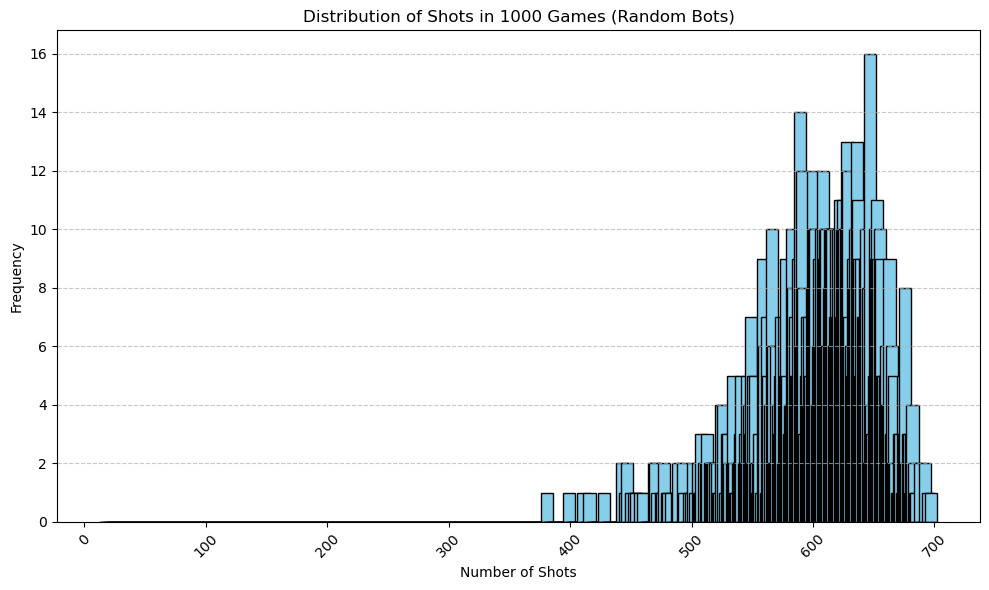

In [6]:

import matplotlib.pyplot as plt
import numpy as np

num_games = 1000
n_shots = []
wins1 = 0
wins2 = 0

for i in range(num_games):
    game = Game(human1=False, human2=False)
    while not game.over:
        if game.player1_turn:
            game.randombot()
        else:
            game.randombot()
    n_shots.append(game.n_shots)
    if game.result == 1:
        wins1 += 1
    else:
        wins2 += 1

# Count occurrences of shots (histogram)
count, bins = np.histogram(n_shots, bins=range(17, 700))  # Use numpy.histogram

# Customize the plot for better aesthetics
plt.figure(figsize=(10, 6))  # Set figure size for readability
plt.bar(bins[:-1], count, width=10, color='skyblue', edgecolor='black') 
plt.xlabel('Number of Shots')
plt.ylabel('Frequency')
plt.title('Distribution of Shots in 1000 Games (Random Bots)')
plt.grid(axis='y', linestyle='--', alpha=0.7)  
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()

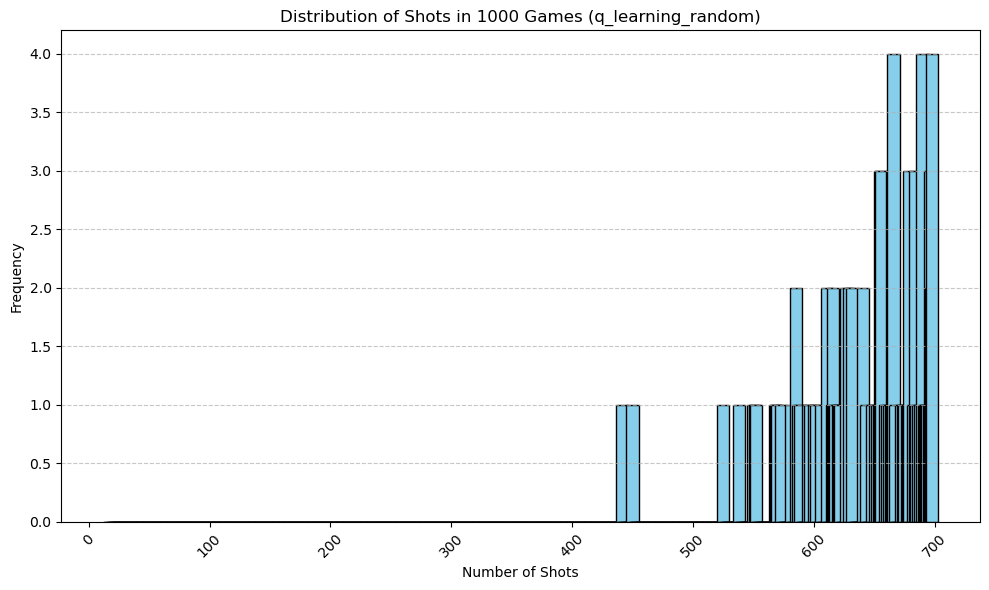

In [8]:
num_games = 1000
n_shots = []
wins1 = 0
wins2 = 0

for i in range(num_games):
    game = Game(human1=False, human2=False)
    while not game.over:
        if game.player1_turn:
            game.q_learning_epsilon()
        else:
            game.q_learning_epsilon()
    n_shots.append(game.n_shots)
    if game.result == 1:
        wins1 += 1
    else:
        wins2 += 1

# Count occurrences of shots (histogram)
count, bins = np.histogram(n_shots, bins=range(17, 700))  # Use numpy.histogram

# Customize the plot for better aesthetics
plt.figure(figsize=(10, 6))  
plt.bar(bins[:-1], count, width=10, color='skyblue', edgecolor='black')  # Adjust bar width and color
plt.xlabel('Number of Shots')
plt.ylabel('Frequency')
plt.title('Distribution of Shots in 1000 Games (q_learning_random)')
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.xticks(rotation=45)  
plt.tight_layout()  

plt.show()

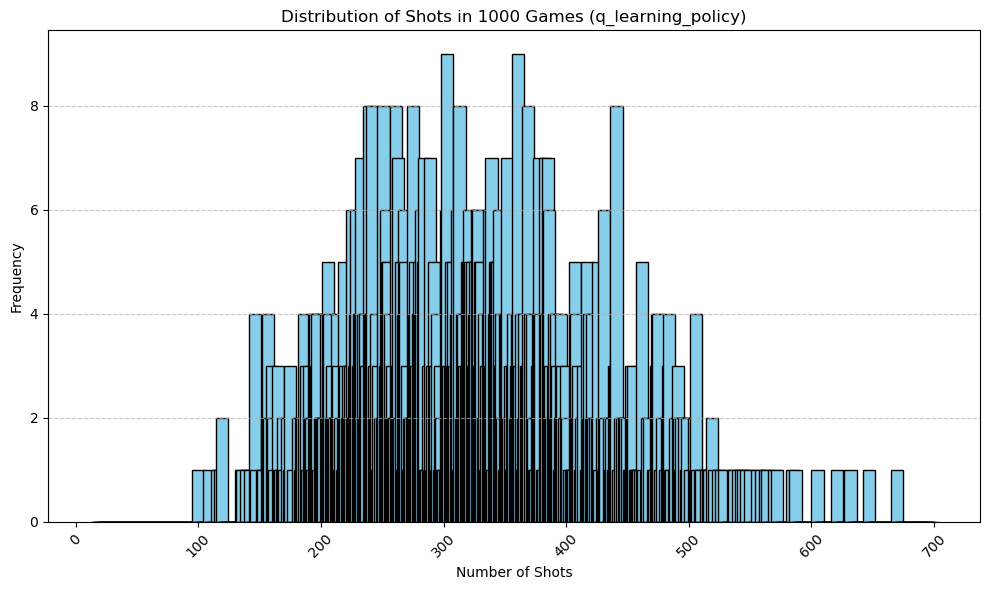

In [9]:
num_games = 1000
n_shots = []
wins1 = 0
wins2 = 0

for i in range(num_games):
    game = Game(human1=False, human2=False)
    while not game.over:
        if game.player1_turn:
            game.q_learning_policy()
        else:
            game.q_learning_policy()
    n_shots.append(game.n_shots)
    if game.result == 1:
        wins1 += 1
    else:
        wins2 += 1

# Count occurrences of shots (histogram)
count, bins = np.histogram(n_shots, bins=range(17, 700))  # Use numpy.histogram

# Customize the plot for better aesthetics
plt.figure(figsize=(10, 6))  
plt.bar(bins[:-1], count, width=10, color='skyblue', edgecolor='black')  # Adjust bar width and color
plt.xlabel('Number of Shots')
plt.ylabel('Frequency')
plt.title('Distribution of Shots in 1000 Games (q_learning_policy)')
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.xticks(rotation=45)  
plt.tight_layout()  

plt.show()